<a href="https://colab.research.google.com/github/madan20maccccc/cross-camera-player-mapping/blob/main/cross_camera_mapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🔧 1. Setup & Install Dependencies


In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install ultralytics --quiet
!pip install torch torchvision --quiet


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 39.7 MB/s eta 0:00:

## 📂 2. Load Model and Define File Paths


In [2]:


# File paths
VIDEO_DIR = '/content/drive/MyDrive/int1'
BROADCAST_PATH = f'{VIDEO_DIR}/broadcast.mp4'
TACTICAM_PATH = f'{VIDEO_DIR}/tacticam.mp4'
MODEL_PATH = f'{VIDEO_DIR}/best.pt'


In [3]:
!pip install ultralytics opencv-python-headless pandas tqdm


In [4]:
from ultralytics import YOLO

# Load the fine-tuned YOLOv11 model (Ultralytics)
model = YOLO(MODEL_PATH)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## 🎯 3. Player Detection and Cropping


In [5]:
import cv2
import os
import pandas as pd
from tqdm import tqdm

def detect_and_save_players(video_path, output_dir, label):
    os.makedirs(output_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    frame_id = 0
    data = []

    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            break

        results = model(frame)[0]

        for i, box in enumerate(results.boxes):
            cls_id = int(box.cls[0])
            if model.names[cls_id] != "player":
                continue

            x1, y1, x2, y2 = map(int, box.xyxy[0])
            player_crop = frame[y1:y2, x1:x2]

            crop_path = f"{output_dir}/{label}_frame{frame_id}_player{i}.jpg"
            cv2.imwrite(crop_path, player_crop)

            data.append({
                'frame': frame_id,
                'player_idx': i,
                'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2,
                'crop_path': crop_path
            })

        frame_id += 1

    cap.release()
    return pd.DataFrame(data)


In [6]:
# Run detection and save cropped players
broadcast_df = detect_and_save_players(BROADCAST_PATH, '/content/broadcast_players', 'broadcast')
tacticam_df = detect_and_save_players(TACTICAM_PATH, '/content/tacticam_players', 'tacticam')



0: 384x640 3 players, 2723.9ms
Speed: 20.7ms preprocess, 2723.9ms inference, 36.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 players, 2590.3ms
Speed: 4.5ms preprocess, 2590.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 players, 2441.5ms
Speed: 4.4ms preprocess, 2441.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 players, 4020.7ms
Speed: 3.4ms preprocess, 4020.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 players, 2618.3ms
Speed: 8.7ms preprocess, 2618.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 players, 1 referee, 2483.7ms
Speed: 4.2ms preprocess, 2483.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 goalkeeper, 12 players, 1 referee, 2476.0ms
Speed: 3.0ms preprocess, 2476.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 1 goalkeeper, 14 player

## 🎨 4. Visual Embedding with CLIP


In [7]:
!pip install torch torchvision ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

import torch
import clip
from PIL import Image
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

def extract_embeddings(df):
    embeddings = []
    for path in tqdm(df['crop_path']):
        image = preprocess(Image.open(path)).unsqueeze(0).to(device)
        with torch.no_grad():
            embedding = clip_model.encode_image(image)
        embeddings.append(embedding.cpu().numpy().flatten())
    return embeddings


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.6 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-7xkh2zuy
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-7xkh2zuy
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=21f99881344df1e0832b62a97f5b6ac657f710ce2d8bc3eb0b40741447277d2a
  Stored in directory: /tmp/pip-ephem-wheel-cache-n0dhsste/wheels/3f/7c/a4/9b490845988bf7a4db33674d52f709f088f64392063872eb9a
Successfully built clip


100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 113MiB/s]


In [8]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

broadcast_df['embedding'] = extract_embeddings(broadcast_df)
tacticam_df['embedding'] = extract_embeddings(tacticam_df)

# Compute pairwise similarity
similarity_matrix = cosine_similarity(np.vstack(tacticam_df['embedding']),
                                      np.vstack(broadcast_df['embedding']))

# Get best match for each tacticam player
mapped_ids = similarity_matrix.argmax(axis=1)
tacticam_df['matched_broadcast_player'] = mapped_ids


100%|██████████| 4309/4309 [19:55<00:00,  3.60it/s]


In [9]:
mapped_result = tacticam_df[['frame', 'player_idx', 'matched_broadcast_player']]
mapped_result.to_csv('/content/player_mapping.csv', index=False)
print("✅ Mapping complete. Saved to /content/player_mapping.csv")


✅ Mapping complete. Saved to /content/player_mapping.csv


## 📍 5. Spatial Coordinate Normalization


In [10]:
# Add center coordinates
for df in [broadcast_df, tacticam_df]:
    df['center_x'] = (df['x1'] + df['x2']) / 2
    df['center_y'] = (df['y1'] + df['y2']) / 2

# Normalize for spatial fairness (set frame resolution)
FRAME_WIDTH, FRAME_HEIGHT = 1280, 720  # Change if different
for df in [broadcast_df, tacticam_df]:
    df['center_x_norm'] = df['center_x'] / FRAME_WIDTH
    df['center_y_norm'] = df['center_y'] / FRAME_HEIGHT


## 🔗 6. Player Matching using Visual + Spatial Similarity


In [11]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cdist
import numpy as np

# Convert embeddings to numpy arrays
broadcast_embeddings = np.vstack(broadcast_df['embedding'])
tacticam_embeddings = np.vstack(tacticam_df['embedding'])

# 1. Visual similarity (cosine)
visual_sim = cosine_similarity(tacticam_embeddings, broadcast_embeddings)

# 2. Spatial distance (Euclidean)
broadcast_pos = broadcast_df[['center_x_norm', 'center_y_norm']].values
tacticam_pos = tacticam_df[['center_x_norm', 'center_y_norm']].values
spatial_dist = cdist(tacticam_pos, broadcast_pos, metric='euclidean')

# 3. Combined score (tune weight as needed)
combined_score = visual_sim - 0.5 * spatial_dist  # alpha=0.5 is penalty weight

# 4. Get best match index for each tacticam player
best_matches = combined_score.argmax(axis=1)
tacticam_df['matched_broadcast_player'] = best_matches


## 💾 7. Save Mapping to CSV


In [12]:
tacticam_df[['frame', 'player_idx', 'matched_broadcast_player']].to_csv(
    '/content/player_mapping.csv', index=False
)

print("✅ Final spatial-aware mapping saved to /content/player_mapping.csv")


✅ Final spatial-aware mapping saved to /content/player_mapping.csv


## 🖼️ 8. Visualize Matched Players (Optional)


In [13]:
import matplotlib.pyplot as plt
import cv2

def show_matched_players(tacticam_df, broadcast_df, num_samples=5):
    plt.figure(figsize=(10, 4 * num_samples))

    for idx in range(num_samples):
        row = tacticam_df.iloc[idx]
        broadcast_id = row['matched_broadcast_player']
        try:
            broadcast_row = broadcast_df.iloc[broadcast_id]

            img1 = cv2.imread(row['crop_path'])
            img2 = cv2.imread(broadcast_row['crop_path'])

            img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
            img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

            plt.subplot(num_samples, 2, 2*idx+1)
            plt.imshow(img1)
            plt.title(f"Tacticam Player {row['player_idx']} (Frame {row['frame']})")
            plt.axis('off')

            plt.subplot(num_samples, 2, 2*idx+2)
            plt.imshow(img2)
            plt.title(f"Matched Broadcast Player ID: {broadcast_id}")
            plt.axis('off')

        except:
            continue

    plt.tight_layout()
    plt.show()


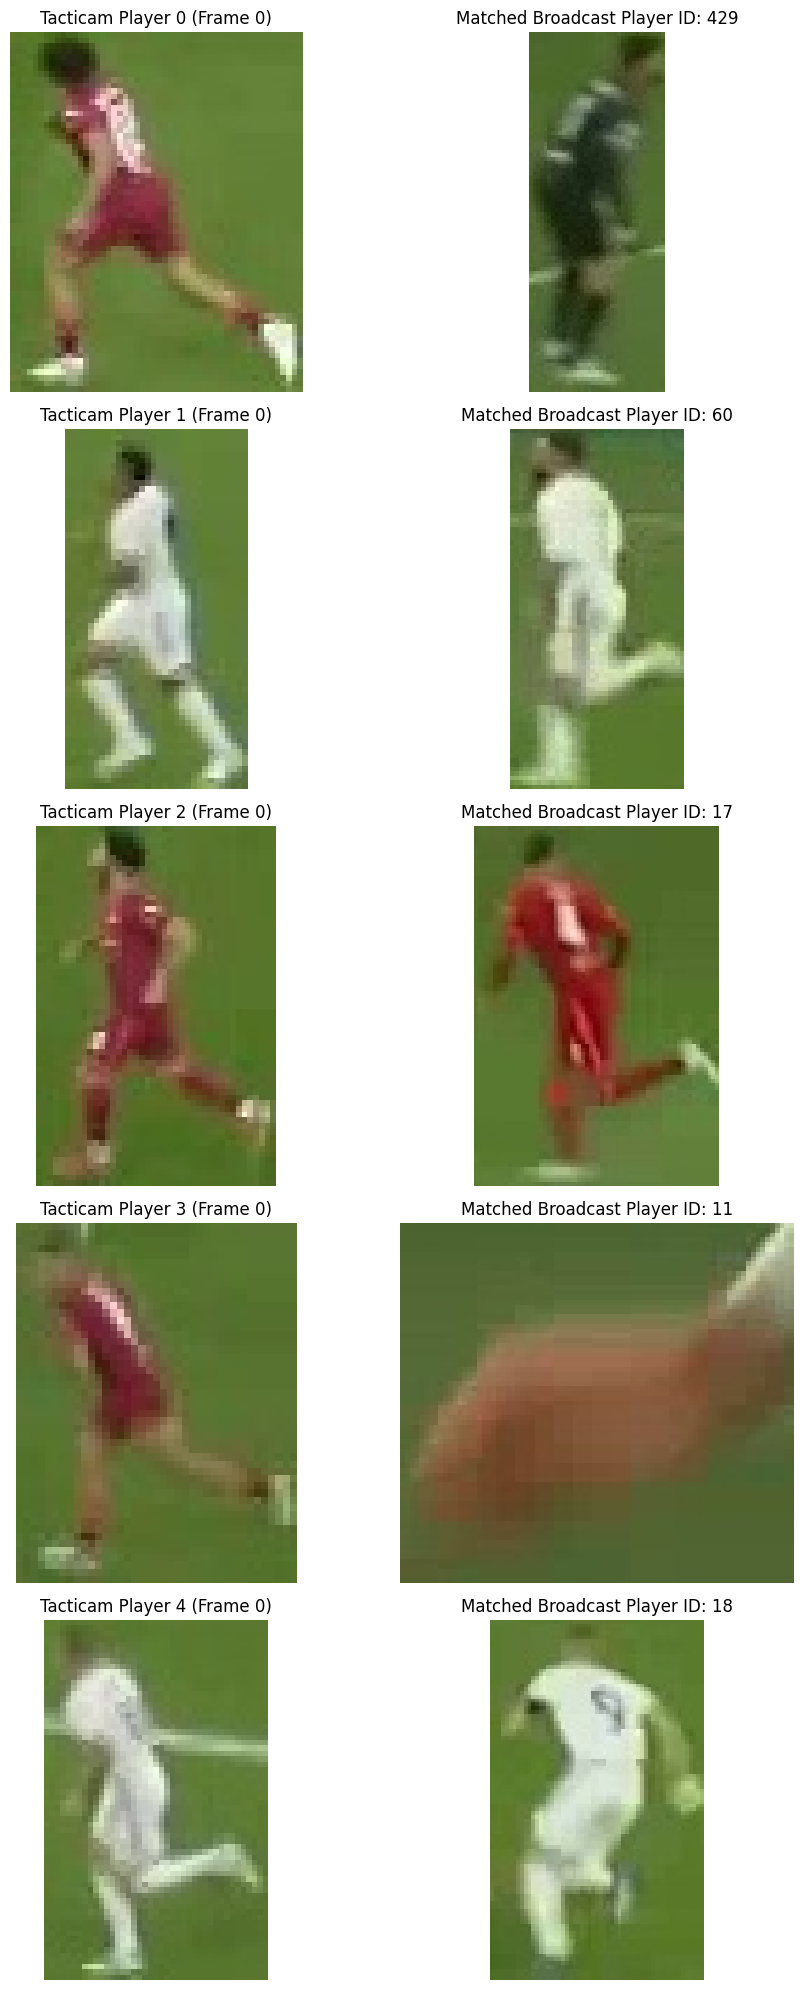

In [14]:
show_matched_players(tacticam_df, broadcast_df, num_samples=5)


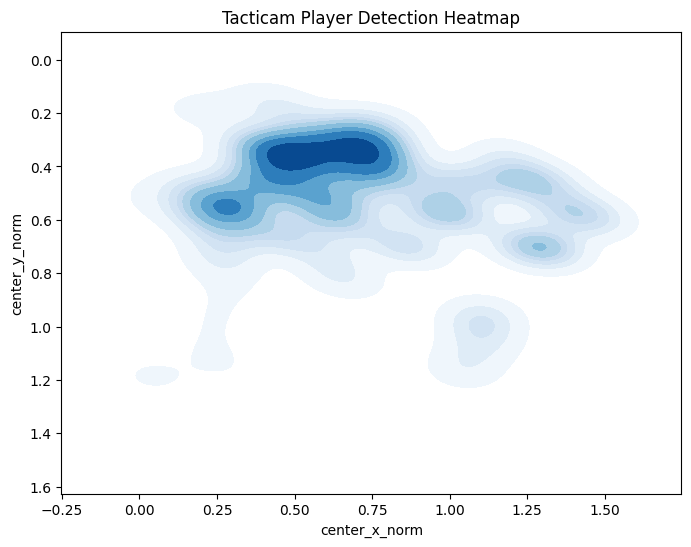

In [15]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.kdeplot(data=tacticam_df, x='center_x_norm', y='center_y_norm', fill=True, cmap='Blues')
plt.title('Tacticam Player Detection Heatmap')
plt.gca().invert_yaxis()
plt.show()


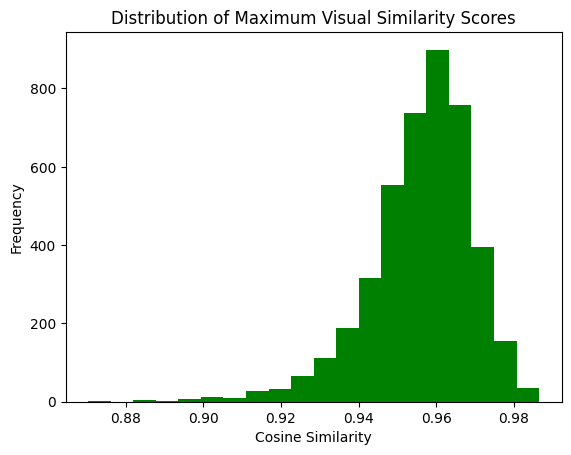

In [16]:
similarities = cosine_similarity(np.vstack(tacticam_df['embedding']),
                                 np.vstack(broadcast_df['embedding']))
max_similarities = similarities.max(axis=1)

plt.hist(max_similarities, bins=20, color='green')
plt.title('Distribution of Maximum Visual Similarity Scores')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()


In [17]:
bad_matches = np.where(max_similarities < 0.6)[0]
print(f"Low-confidence matches found: {len(bad_matches)}")


Low-confidence matches found: 0


## 📤 9. Save Outputs to Google Drive (Permanent)


In [18]:
import shutil
import os

# Target folders inside Drive
target_dir = "/content/drive/MyDrive/int1"
broadcast_target = os.path.join(target_dir, "broadcast_players")
tacticam_target = os.path.join(target_dir, "tacticam_players")

# Copy broadcast and tacticam cropped image folders
shutil.copytree("/content/broadcast_players", broadcast_target, dirs_exist_ok=True)
shutil.copytree("/content/tacticam_players", tacticam_target, dirs_exist_ok=True)


'/content/drive/MyDrive/int1/tacticam_players'

In [19]:
# Save the final mapping CSV to Drive
shutil.copy("/content/player_mapping.csv", target_dir)

print("✅ All outputs saved to Google Drive (/MyDrive/int1)")


✅ All outputs saved to Google Drive (/MyDrive/int1)
